In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def pps(k, k_pivot=0.05, logA = 3.04, n_s = 0.965):
    A = np.exp(logA) / 1e10
    return A * (k / k_pivot)**(n_s - 1)

def pps_run(k, k_pivot=0.05, logA = 3.04, n_s = 0.965, alpha_s = -0.0045):
    A = np.exp(logA) / 1e10
    return A * (k / k_pivot)**(n_s - 1 + 0.5 * alpha_s * np.log(k / k_pivot))

def PPS_rescale(parm, k_pivot_old, k_pivot_new):
    log_A_old = parm[0] # 10 + log10_A_s
    n_s = parm[1]
    log_A_new = log_A_old + (n_s - 1) * np.log(k_pivot_new / k_pivot_old)
    return np.array([log_A_new, n_s])

def PPS_run_rescale(parm, k_pivot_old, k_pivot_new):
    log_A_old = parm[0]
    n_s_old = parm[1]
    alpha_s = parm[2]
    k_ratio = np.log(k_pivot_new / k_pivot_old)
    n_s_new = n_s_old + alpha_s * k_ratio
    log_A_new = log_A_old + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2

    return np.array([log_A_new, n_s_new, alpha_s])


<Figure size 1000x600 with 0 Axes>

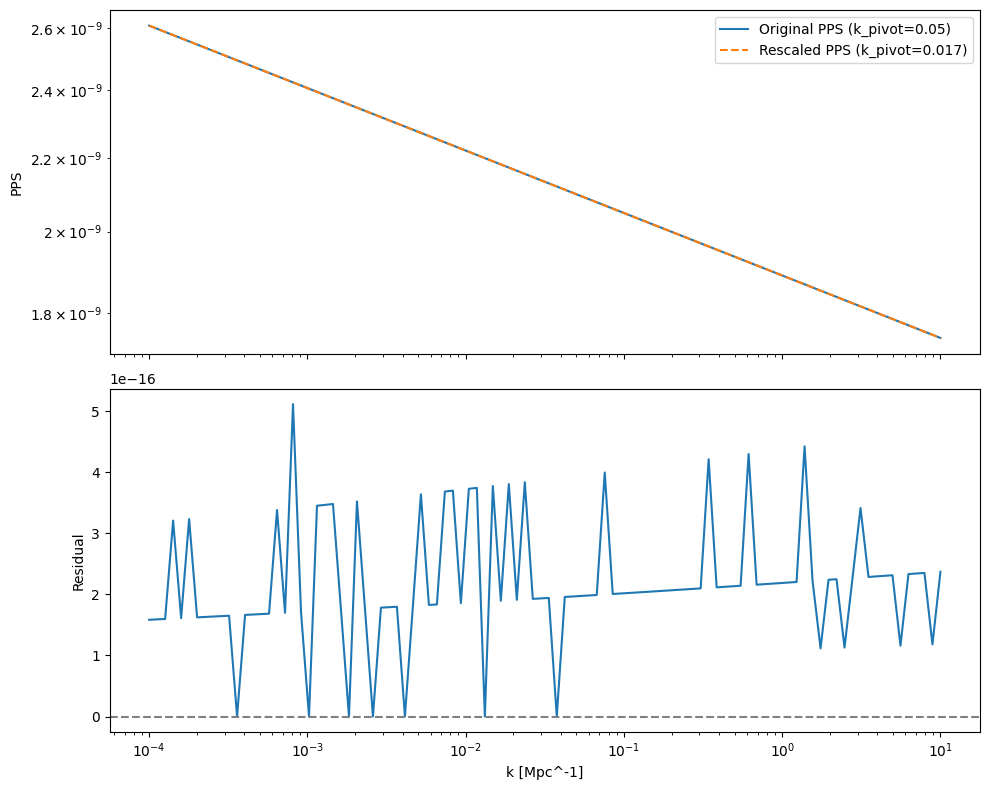

In [88]:
karr = np.logspace(-4, 1, 100)
pps_parm = np.array([3.044, 0.965])

pk_old = pps(karr, k_pivot=0.05, logA=pps_parm[0], n_s=pps_parm[1])
pps_new_parm = PPS_rescale(pps_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_new = pps(karr, k_pivot=0.017, logA=pps_new_parm[0], n_s=pps_new_parm[1])
pk_new = pps(karr, k_pivot=0.017, logA=pps_new_parm[0], n_s=pps_new_parm[1])
residual = (pk_new - pk_old) / pk_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_old, label='Original PPS (k_pivot=0.05)')
ax[0].loglog(karr, pk_new, linestyle='--', label='Rescaled PPS (k_pivot=0.017)')
ax[0].set_ylabel('PPS')
ax[0].legend()
ax[1].semilogx(karr, residual)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show() 


<Figure size 1000x600 with 0 Axes>

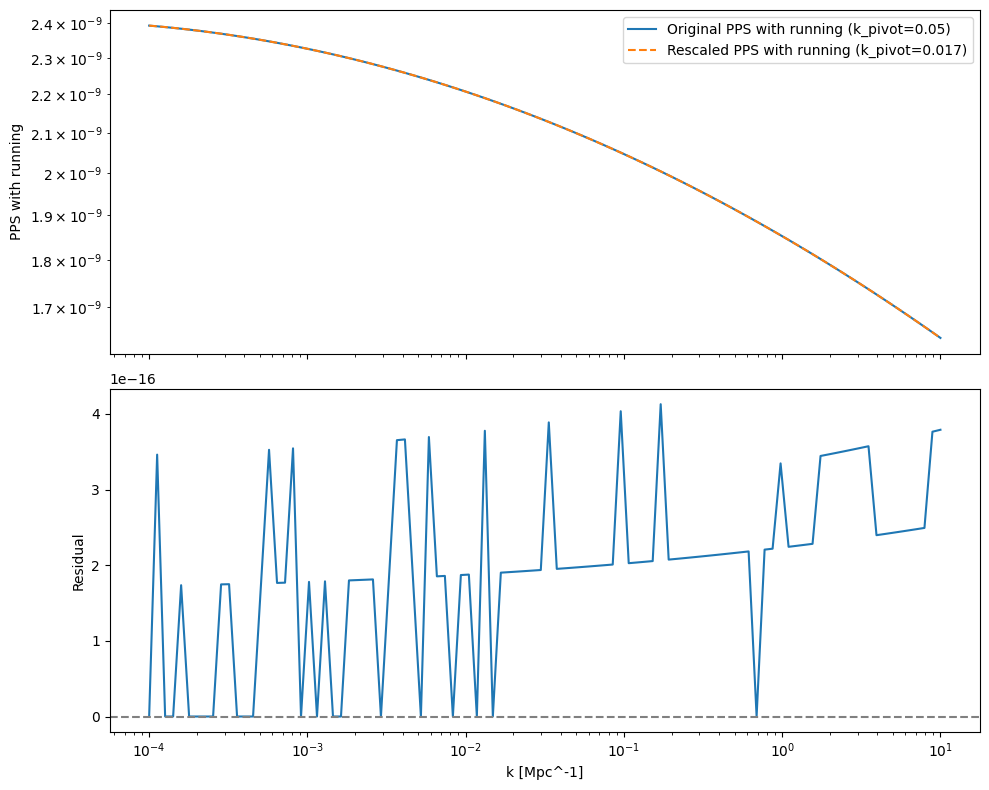

In [89]:
karr = np.logspace(-4, 1, 100)
pps_run_parm = np.array([3.044, 0.965, -0.0045])
pk_run_old = pps_run(karr, k_pivot=0.05, logA=pps_run_parm[0], n_s=pps_run_parm[1], alpha_s=pps_run_parm[2])
pps_run_new_parm = PPS_run_rescale(pps_run_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_run_new = pps_run(karr, k_pivot=0.017, logA=pps_run_new_parm[0], n_s=pps_run_new_parm[1], alpha_s=pps_run_new_parm[2])
residual_run = (pk_run_new - pk_run_old) / pk_run_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_run_old, label='Original PPS with running (k_pivot=0.05)')
ax[0].loglog(karr, pk_run_new, linestyle='--', label='Rescaled PPS with running (k_pivot=0.017)')
ax[0].set_ylabel('PPS with running')
ax[0].legend()
ax[1].semilogx(karr, residual_run)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [15]:
chain_paramnames = open('./plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE.paramnames').readlines()
chain1 = np.loadtxt('./plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE_1.txt')

In [28]:
for i in range(len(chain_paramnames)):
    inum = chain_paramnames[i].find('\t')
    chain_paramnames[i] = chain_paramnames[i][:inum]

In [36]:
chain_paramnames[6]

'nrun'

In [39]:
chain1_orig = pd.DataFrame({
    'weights' : chain1[:,0],
    'likelihood' : chain1[:,1],
    f'{chain_paramnames[4]}' : chain1[:,4],
    f'{chain_paramnames[5]}' : chain1[:,7],
    f'{chain_paramnames[6]}' : chain1[:,8]
})

In [168]:
chain1_rescale = chain1_orig.copy()
chain1_rescale.iloc[:,2:] = PPS_run_rescale(chain1_orig.iloc[:,2:].values.T, k_pivot_old=0.05, k_pivot_new=0.039).T

Removed no burn in
Removed no burn in


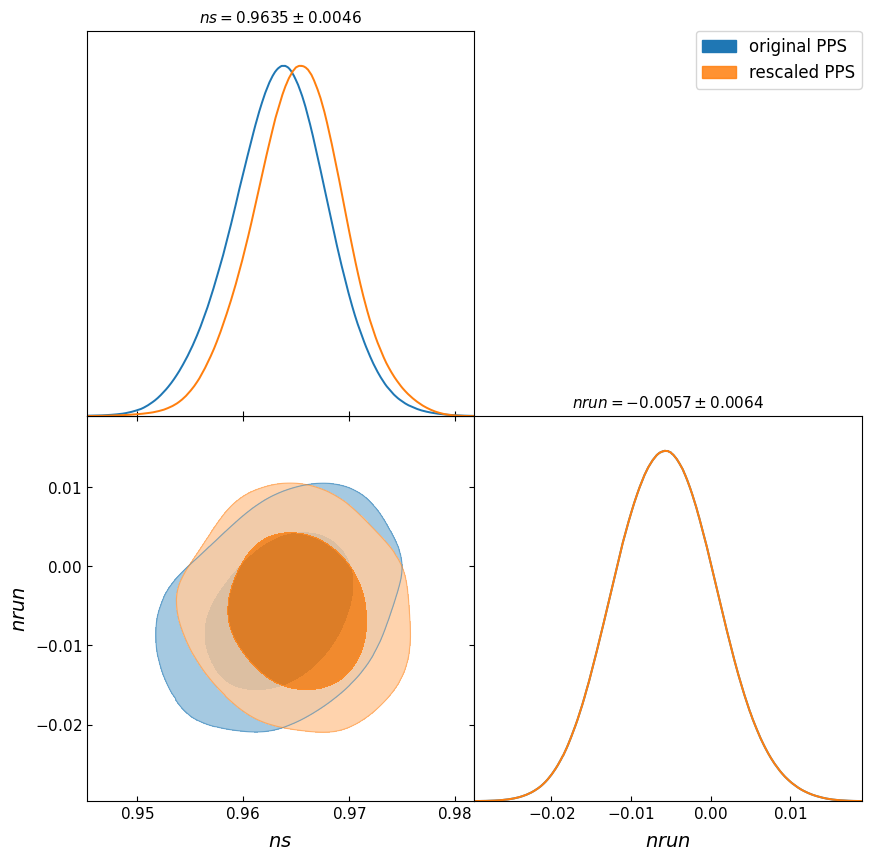

In [159]:
from getdist import plots, MCSamples

sample_orig = MCSamples(
    samples=chain1_orig.iloc[:,3:].values,
    weights=chain1_orig['weights'].values,
    loglikes = chain1_orig['likelihood'].values,
    names=chain_paramnames[5:7],
    labels=chain_paramnames[5:7],
    label='Original PPS'
)
sample_resc = MCSamples(
    samples=chain1_rescale.iloc[:,3:].values,
    weights=chain1_rescale['weights'].values,
    loglikes = chain1_rescale['likelihood'].values,
    names=chain_paramnames[5:7],
    labels=chain_paramnames[5:7],
    label='rescaled PPS'
)
g0 = plots.get_subplot_plotter(width_inch=10)
g0.triangle_plot([sample_orig, sample_resc], filled=True,
                 title_limit=1, legend_labels = ['original PPS', 'rescaled PPS'],
                legend_loc='upper right', contour_colors=['C0', 'C1'], contour_lw=2, contour_ls='solid'
                )

In [175]:
mean_orig = sample_orig.getMeans()
mean_resc = sample_resc.getMeans()
print(mean_orig)
print(mean_resc)

[ 0.96350995 -0.00566707]
[ 0.96521633 -0.00566707]


In [ ]:
def get_optimal_pivot(data):
    n_s = data


In [169]:
cov_mat = np.cov(chain1_orig.iloc[:,3:], aweights=chain1_orig['weights'], rowvar=False)
cov_mat_resc = np.cov(chain1_rescale.iloc[:,3:], aweights=chain1_rescale['weights'], rowvar=False)

In [190]:
class PPSchain:
    def __init__(self, chainfile, parmfile, k_pivot=0.05):
        _arr = open(parmfile).readlines()
        _parmnames = []
        for i in range(len(_arr)):
            inum = _arr[i].find('\t')
            _parmnames.append(_arr[i][:inum])
        self.parmnames = _parmnames
        if type(chainfile) == str:
            _chain = np.loadtxt(chainfile)
            self.chain = pd.DataFrame({
                'weights' : _chain[:,0],
                'likelihood' : _chain[:,1],
                f'{self.parmnames[4]}' : _chain[:,4],
                f'{self.parmnames[5]}' : _chain[:,7],
                f'{self.parmnames[6]}' : _chain[:,8]
                })
        elif type(chainfile) == pd.DataFrame:
            self.chain = chainfile
        self.weights = self.chain['weights'].values
        self.likelihood = self.chain['likelihood'].values
        self.log_A = self.chain[self.parmnames[4]].values
        self.n_s = self.chain[self.parmnames[5]].values
        self.alpha_s = self.chain[self.parmnames[6]].values
        self.k_pivot = k_pivot
        
    def PPS_run_rescale_chain(self, k_pivot_new):
        log_A_old = self.log_A
        n_s_old = self.n_s
        alpha_s = self.alpha_s
        k_ratio = np.log(k_pivot_new / self.k_pivot)
        n_s_new = n_s_old + alpha_s * k_ratio
        log_A_new = log_A_old + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2
        
        return np.array([log_A_new, n_s_new, alpha_s]).T, k_pivot_new
    
    def get_uncorr_k(self):
        from scipy.optimize import fsolve
        def cov_func(self, k):
            _shift = self.PPS_run_rescale_chain(k)
            cov_mat = np.cov(_shift[:,1], _shift[:,2], aweights=self.weights, rowvar=False)
            cov_val = cov_mat[0,1]
            return cov_val
        val, info, ier, msg = fsolve(cov_func, x0 = 0.017, full_output=True)
        if ier == 1:
            print(f"최적화 성공: Uncorrelated k_pivot = {val[0]:.5f}")
            return val[0]
        else:
            print(f"최적화 실패: {msg}")
            return None

        

In [193]:
chainfile = './plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE_1.txt'
parmfile = './plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE.paramnames'
p = PPSchain(chainfile, parmfile, k_pivot=0.05)
